In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install torch
# pip install transformers 
# -> 변경 : 최신 버전으로 설치하면 "Input: must be Tensor, not str" 라는 에러 발생 
!pip install transformers==3

In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-f6xxd0k4
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-f6xxd0k4
  Created wheel for kobert: filename=kobert-0.1.2-cp37-none-any.whl size=12708 sha256=fbd3fdb7cb01c20ce69604a3b0ceee0324c875cb285d2741afc75780a49fffa2
  Stored in directory: /tmp/pip-ephem-wheel-cache-ld50jn6f/wheels/a2/b0/41/435ee4e918f91918be41529283c5ff86cd010f02e7525aecf3
Successfully built kobert


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [ ]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

In [ ]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
# GPU 사용 시
# device = torch.device("cuda:0")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
bertmodel, vocab = get_pytorch_kobert_model() 

[██████████████████████████████████████████████████]
[██████████████████████████████████████████████████]


In [ ]:
vocab

Vocab(size=8002, unk="[UNK]", reserved="['[CLS]', '[SEP]', '[MASK]', '[PAD]']")

# 데이터 확인

In [ ]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/KED 공모전/Data/embedding/noun_extracted_train_without_OOV.txt',sep='\t',encoding = "UTF-8")

In [ ]:
import ast

data['BZ_PPOS_ITM_CTT'] = data['BZ_PPOS_ITM_CTT'].apply(lambda x : ast.literal_eval(x))
data['BZ_PPOS_ITM_CTT'] = data['BZ_PPOS_ITM_CTT'].apply(lambda x : " ".join(x))

In [ ]:
data

,BZ_PPOS_ITM_CTT,KSIC10_BZC_CD
0,창고업 서비스업 부동산 임대업 자동차 부품 제조업,G45211
1,인쇄업 부동산 임대업 종이 가방 종이 쇼핑백 종이 상자 비닐 가방 비닐 쇼핑백 도매...,C17221
2,의류 피혁 완구 완 농 외 식품 기타 각종 일용품 제조 가공 사업 각종 오락장 식음...,G47111
3,방식 기계 기기 제작 재료 판매업 방 그 관련 제반 사업 전자 제품 생산 판매업 물...,F42311
4,금속 비금속 광물 채광 자원 개발 제련 판매 금속 비금속 합금 가공 제품 제조 판매...,C24211
...,...,...
1531451,가구 내 고용 활동,S96999
1531452,자 소비 가사 생산 활동,T97000
1531453,자 소비 가사 서비스 활동,T98100
1531454,주한 외국 공관,T98200


In [ ]:
data['KSIC10_BZC_CD'] = data['KSIC10_BZC_CD'].astype(str)

from sklearn.preprocessing import LabelEncoder 
encoder = LabelEncoder() 
encoder.fit(data['KSIC10_BZC_CD']) 
data['KSIC10_BZC_CD'] = encoder.transform(data['KSIC10_BZC_CD']) 
data.head()

,BZ_PPOS_ITM_CTT,KSIC10_BZC_CD
0,창고업 서비스업 부동산 임대업 자동차 부품 제조업,597
1,인쇄업 부동산 임대업 종이 가방 종이 쇼핑백 종이 상자 비닐 가방 비닐 쇼핑백 도매...,171
2,의류 피혁 완구 완 농 외 식품 기타 각종 일용품 제조 가공 사업 각종 오락장 식음...,700
3,방식 기계 기기 제작 재료 판매업 방 그 관련 제반 사업 전자 제품 생산 판매업 물...,583
4,금속 비금속 광물 채광 자원 개발 제련 판매 금속 비금속 합금 가공 제품 제조 판매...,296


In [ ]:
# 인코딩 결과 확인
mapping = dict(zip(range(len(encoder.classes_)), encoder.classes_)) 
mapping

In [ ]:
len(data['KSIC10_BZC_CD'].unique())

1196

In [ ]:
from sklearn.model_selection import train_test_split 
dataset_train, dataset_test = train_test_split(data , test_size=0.2, random_state=42) 

print("train shape is:", dataset_train.shape) 
print("test shape is:", dataset_test.shape)

train shape is: (1225164, 2)
test shape is: (306292, 2)


# BERT

In [ ]:
tokenizer = get_tokenizer() #Tokenizer for the sentences.
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False) # vocab : The vocabulary which has cls_token and sep_token registered.

using cached model


In [ ]:
class BERTDataset(Dataset):
  def __init__(self, dataset,bert_tokenizer, max_len,pad, pair):
    # https://nlp.gluon.ai/api/modules/data.html#gluonnlp.data.BERTSentenceTransform
    transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
    # transform의 return : 
    # np.array (input token ids in ‘int32’, shape (batch_size, seq_length))
    # np.array (valid length in ‘int32’, shape (batch_size,))
    # np.array (input token type ids in ‘int32’, shape (batch_size, seq_length))

    self.sentences = [transform([i]) for i in dataset['BZ_PPOS_ITM_CTT']] #sentence 넣는 곳
    self.labels = [np.int32(i) for i in dataset['KSIC10_BZC_CD']] #label 넣는 곳

  def __getitem__(self, i):
      return (self.sentences[i] + (self.labels[i], ))

  def __len__(self):
      return (len(self.labels))


In [ ]:
## Setting parameters
max_len = 128 # 해당 길이를 초과하는 단어에 대해선 bert가 학습하지 않음
batch_size = 32
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
# 데이터를 bert 모델에서 사용할 수 있도록 transform 시켜주는 코드
# token_ids, valid_length, segment_ids, label 을 리턴!
data_train = BERTDataset(dataset_train, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, tok, max_len, True, False)

In [ ]:
data_train[825164]

(array([   2, 4049, 2459,  517, 5859, 2822, 6168, 6873, 4049, 2459, 1083,
        2114, 6873, 4049, 2459, 4152,  993, 6705, 7020, 3517, 3260, 2852,
         839, 3260,    3,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(25, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


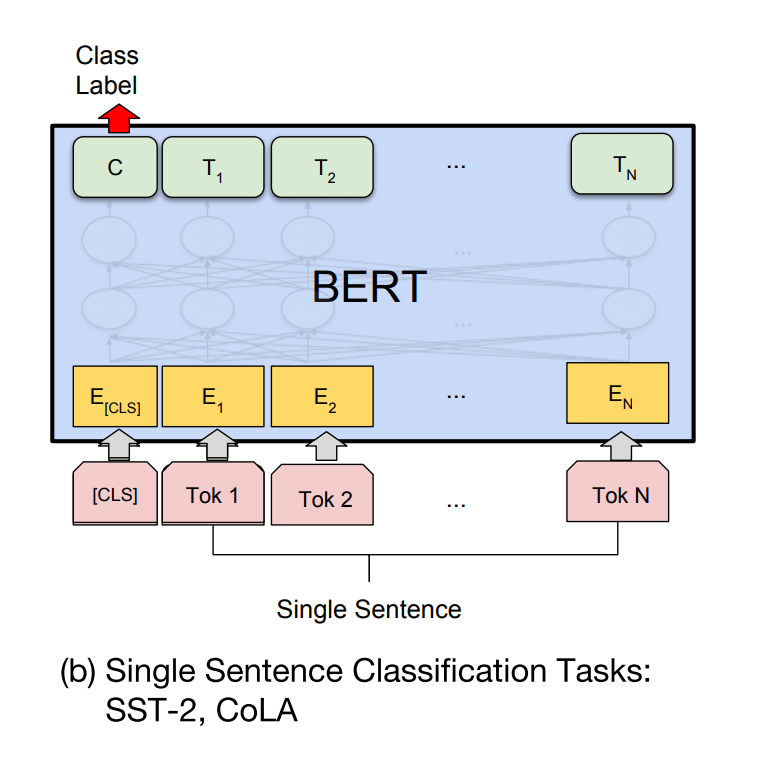

bert 모델을 거치고 나온 첫 토큰을 pooler 라고 네이밍. (the representation corresponding to the first token in the output is used for fine-tuning)
이 pooler 결과를 받아 FC(fully connected) 레이어 하나를 추가해 bert model을 fine-tuning 할 수 있음. 


해당 그림에서

* [C] : `pooler` 벡터
* [C,T1,T2... ] : `sequence_output[N]` 벡터라고 할 수 있습니다:)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768, # Dimensionality of the encoder layers and the pooler layer
                 num_classes = 1196, # 분류할 class label의 개수                
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps = 1e-8) # 0으로 나누는 것을 방지하기 위한 epsilon 값
loss_fn = nn.CrossEntropyLoss()

In [ ]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [ ]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
PATH = '/content/drive/MyDrive/KED 공모전/weights/'

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train() # eval -> train mode로 전환
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        # optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        model.zero_grad()         # 그래디언트 초기화
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval() # train -> eval mode로 전환 (평가 모드는 훈련에 사용되는 드롭아웃 정규화(dropout regularization)를 해제한다.)
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

    torch.save({
     'epoch' : e+1,
     'model_state_dict': model.state_dict(),
     'optimizer_state_dict': optimizer.state_dict()
     }, PATH + 'model_{}.tar'.format(e+1) )



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 6.698431491851807 train acc 0.03125
epoch 1 batch id 201 loss 6.5675554275512695 train acc 0.04306592039800995
epoch 1 batch id 401 loss 6.1411004066467285 train acc 0.04558915211970075
epoch 1 batch id 601 loss 6.379662990570068 train acc 0.04430116472545757
epoch 1 batch id 801 loss 6.169991493225098 train acc 0.04611423220973783
epoch 1 batch id 1001 loss 6.130430221557617 train acc 0.048701298701298704
epoch 1 batch id 1201 loss 5.9627814292907715 train acc 0.05183180682764363
epoch 1 batch id 1401 loss 6.10211706161499 train acc 0.05397930049964311
epoch 1 batch id 1601 loss 5.934279918670654 train acc 0.056546689569019364
epoch 1 batch id 1801 loss 6.060150623321533 train acc 0.059897279289283734
epoch 1 batch id 2001 loss 5.709214210510254 train acc 0.06329647676161919
epoch 1 batch id 2201 loss 5.31351375579834 train acc 0.06712857791912767
epoch 1 batch id 2401 loss 5.803654670715332 train acc 0.07075177009579342
epoch 1 batch id 2601 loss 5.19719982147

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch 1 test acc 0.5179024759715838


epoch 2 batch id 1 loss 2.2691776752471924 train acc 0.5
epoch 2 batch id 201 loss 1.6949055194854736 train acc 0.4975124378109453
epoch 2 batch id 401 loss 1.8526620864868164 train acc 0.503428927680798
epoch 2 batch id 601 loss 2.718635320663452 train acc 0.500103993344426
epoch 2 batch id 801 loss 2.356433153152466 train acc 0.4988295880149813
epoch 2 batch id 1001 loss 2.588104009628296 train acc 0.49803321678321677
epoch 2 batch id 1201 loss 1.8864445686340332 train acc 0.49862094088259784
epoch 2 batch id 1401 loss 2.303121566772461 train acc 0.5004461099214846
epoch 2 batch id 1601 loss 2.434843063354492 train acc 0.5024398813241724
epoch 2 batch id 1801 loss 2.267906665802002 train acc 0.5036611604664075
epoch 2 batch id 2001 loss 3.260470390319824 train acc 0.5036544227886057
epoch 2 batch id 2201 loss 2.1292240619659424 train acc 0.5043872103589278
epoch 2 batch id 2401 loss 3.107167959213257 train acc 0.5032668679716785
epoch 2 batch id 2601 loss 2.3647546768188477 train acc

In [ ]:
# checkpoint = torch.load(PATH + 'all.tar')   # dict 불러오기
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])